In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob, subprocess
import geopandas as gpd # or working with shapefiles/vector data
import rasterio as rio # for reading rasters
from rasterio.plot import show
from osgeo import ogr #for manipulating geospatial vector data
from osgeo import gdal # for manipulating geospatial raster data
from shapely.geometry import box
from shapely import wkt
import matplotlib.pyplot as plt
import descartes
from shapely import speedups
speedups.disable()
import tracemalloc
import fiona
import rasterio.mask
import zipfile
import dask.array as da
from IPython.display import Image
from rasterio.merge import merge
import time
import rioxarray # for align rasters
st=time.time()
tracemalloc.start()
import warnings
warnings.filterwarnings('ignore')

In [3]:
def checkm():
    #Print out current memory usage and peak memory usage
    size, peak = tracemalloc.get_traced_memory()
    size=size/1024/1024/1024
    peak=peak/1024/1024/1024
    print('Current Size:',round(size,3),'GB, Peak Usage:',round(peak,3),'GB')
    
def kmz_to_shp(folder_dir,name):
    """Convert kmz to shapefile.
    """
    file_fir=f'{folder_dir}/{name}'
    with zipfile.ZipFile(glob.glob(f'{file_fir}/*.kmz')[0],"r") as zip_ref:
        zip_ref.extractall(f'{file_fir}')
    for i in glob.glob(f'{file_fir}/*.kml'):
        out=subprocess.run(["ogr2ogr", "-f", 'ESRI Shapefile', f"{file_fir}/{name}.shp", i])

def geoseries_to_shp(output_dir, geoseries, out_file): 
    """Convert GeoSeries to a GeoDataFrame and finally to a shapefile.
    The envelope of the dissolved wards shapefile is a geoseries, 
    so it needs to be converted to geodf first, then save it as a shapefile.
    """
    geoseries_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geoseries))
    geoseries_gdf.to_file(f'{output_dir}/{out_file}.shp')
    
def rasterize_shp(output_dir, output_file_name, input_file_name, pixel_size):
    """Converts shapefiles to rasters.
    This function takes as arguments the name for the output raster,
    the name of the input shapefile, and pixel size for the resulting raster. 
    Returns raster created from arg2 with pixel size given by arg3, saves as a file named arg1,
    """
    input_file   = f'{output_dir}/{input_file_name}.shp'
    output_file = f'{output_dir}/{output_file_name}'
    input_shp  = ogr.Open(input_file)
    shp_layer  = input_shp.GetLayer()
    xmin, xmax, ymin, ymax = shp_layer.GetExtent()
    if 'bbox' in output_file_name: 
        gdal.Rasterize(output_file, input_file, xRes=pixel_size, yRes=pixel_size, outputBounds = [xmin, ymin, xmax, ymax],burnValues = [0],
                   outputType=gdal.GDT_Byte)
    else: 
        gdal.Rasterize(output_file, input_file, xRes=pixel_size, yRes=pixel_size, outputBounds = [xmin, ymin, xmax, ymax],
                   outputType=gdal.GDT_Byte)
    
def raster_to_png(output_dir,input_raster,output):
    """Convert .tif files to .png and .jpeg using rasterio.
    
    This function converts input raster and output as output.png/.jpeg
    """
    with rio.open(f'{output_dir}/{input_raster}') as infile: 
        profile = infile.profile
        profile['driver'] = 'PNG'
        png_filename = f'{output_dir}/{output}.png'
        raster = infile.read()
        with rio.open(png_filename, 'w', **profile) as dest: 
            dest.write(raster)
        profile['driver'] = 'JPEG'
        jpeg_filename = f'{output_dir}/{output}.jpeg'
        with rio.open(jpeg_filename, 'w', **profile) as dest: 
            dest.write(raster)
            
def rasterize_array(output_dir, input_arr, in_ras, out_ras):
    #generating meta data for out raster using in raster
    driver = gdal.GetDriverByName('GTiff')
    input1 = gdal.Open(f'{output_dir}/{in_ras}.tif')
    band = input1.GetRasterBand(1)
    x_size = input1.RasterXSize
    y_size = input1.RasterYSize
    proj = input1.GetProjection()
    geo_ref = input1.GetGeoTransform()
    out_raster = driver.Create(f'{output_dir}/{out_ras}.tif', x_size, y_size, 1, gdal.GDT_Byte)
    out_raster.GetRasterBand(1).WriteArray(input_arr)
    out_raster.SetProjection(proj)
    out_raster.SetGeoTransform(geo_ref)
    out_raster.FlushCache()

### Merging ward shapefiles into a single geodataframe

In [7]:
wards_gdf = gpd.GeoDataFrame(gpd.read_file(ward_shapefiles[0], crs=crs))
for shapefile in ward_shapefiles[1:]: 
    w_gdf = gpd.read_file(shapefile, crs=crs)
    wards_gdf = gpd.GeoDataFrame(pd.concat([wards_gdf, w_gdf]))
    
if MD_MS_flag==1:
    sea = gpd.read_file(f'{slums_world_dir}/raw/Wards/MS_with_sea/sea.shp')
    wards_gdf = gpd.GeoDataFrame(pd.concat([wards_gdf, sea]))

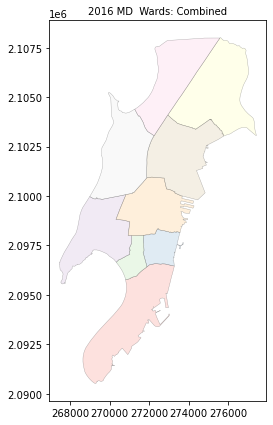

In [8]:
wards_gdf.plot(figsize=(7,7), linewidth=0.4, edgecolor='0.2', alpha=0.4, cmap='Pastel1')
plt.title(f'20{year} {MD_MS_text}  Wards: Combined', fontsize=10)

#### Dissolving boundaries from merged wards to obtain single geometry
- Input: wards shapefiles
- Output: combined wards shapefile

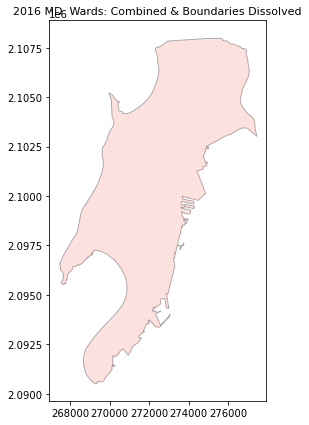

In [9]:
wards_gdf['dissolve_constant'] = 5
wards_gdf = wards_gdf.dissolve(by='dissolve_constant')
wards_gdf.to_file(f'{input_z_out}/combined_wards.shp')
wards_gdf.plot(figsize=(7,7), linewidth=0.9, edgecolor='0.2', alpha=0.4, cmap='Pastel1')
plt.title(f'20{year} {MD_MS_text}  Wards: Combined & Boundaries Dissolved', fontsize=11)

### Obtain the extent of training area
- Output: bounding boxes as shapefiles,wards_bbox.shp

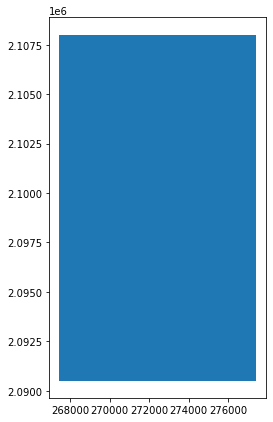

In [10]:
wards_bbox = wards_gdf.envelope
wards_bbox.plot(figsize=(7,7))
geoseries_to_shp(input_z_out, wards_bbox, 'wards_bbox')

### Generate training area raster
Rasterizing merged ward shapefiles<br>
- Input: merged ward shapefiles, combined_wards.shp<br>
- Output: merged ward raster, combined_wards.tif

In [11]:
%%time
rasterize_shp(input_z_out, 'combined_wards.tif', 'combined_wards', pixel_size=cellSize)
checkm()

Current Size: 0.005 GB, Peak Usage: 0.005 GB
Wall time: 153 ms


### Clip input with the ward bounding box shapefile
- input: slum shapefile, "sra1_slum16.shp"; bounding boxes shapefiles, wards_bbox.shp<br>
- output: Clipped slum shapefile, "Slum_2016_Clipped.shp" 

In [14]:
slum_gdf = gpd.read_file(f'{slum_map_dir}/{city}/{city}.shp')
slum_gdf = slum_gdf.to_crs(epsg=32643)
wards_bbox = gpd.read_file(f'{input_z_out}/wards_bbox.shp', crs=crs)
#Clip
slum_clipped = gpd.clip(wards_bbox, slum_gdf) 
slum_clipped.to_file(f'{input_y_out}/Slum_Clipped.shp')
checkm()

Current Size: 0.006 GB, Peak Usage: 0.086 GB
Wall time: 1.43 s


##### visualizing clipped and unclipped slum "shapefiles"

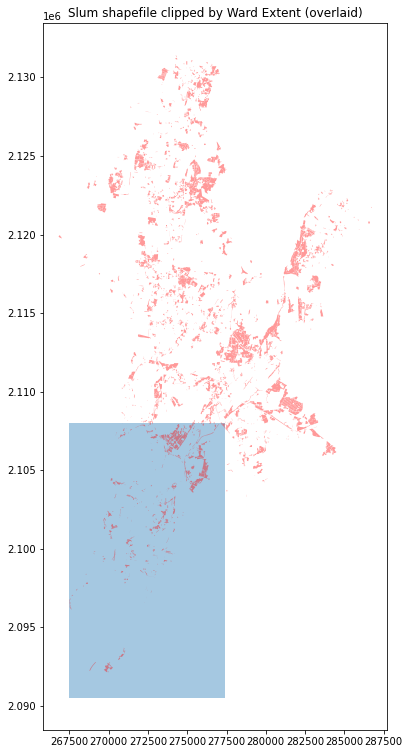

In [16]:
fig, ax = plt.subplots(figsize=(13,13))
wards_bbox.plot(alpha=0.4, ax=ax)
slum_gdf.plot(ax=ax, color='red', alpha=0.4)
plt.title('Slum shapefile clipped by Ward Extent (overlaid)', fontsize=12)

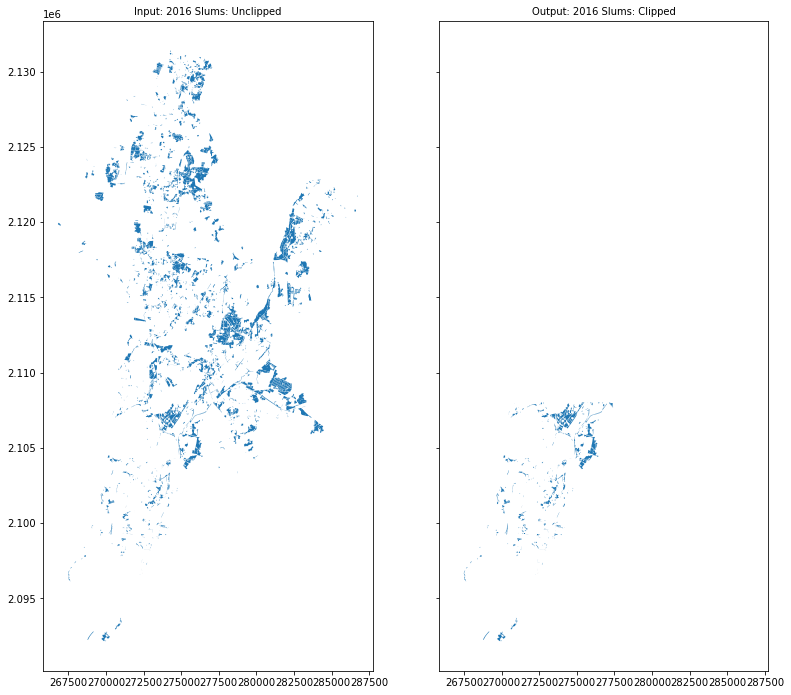

In [33]:
f, ax = plt.subplots(1,2, figsize=(13,13), sharey=True, sharex=True)
slum_gdf.plot(ax=ax[0])
slum_clipped.plot(ax=ax[1])
ax[0].set_title(f'Input: 20{year} Slums: Unclipped', fontsize=10)
ax[1].set_title(f'Output: 20{year} Slums: Clipped', fontsize=10)
plt.show()

### Convert polygons to polylines
- input: clipped slum shapefile as polygon, "Slum_Clipped.shp"
- output: clipped slum shapefile as polylines, 'Slum_Clipped_Lines.shp'

In [18]:
slum_clipped_lines = slum_clipped.boundary
geoseries_to_shp(input_y_out,slum_clipped_lines, f'Slum_Clipped_Lines')

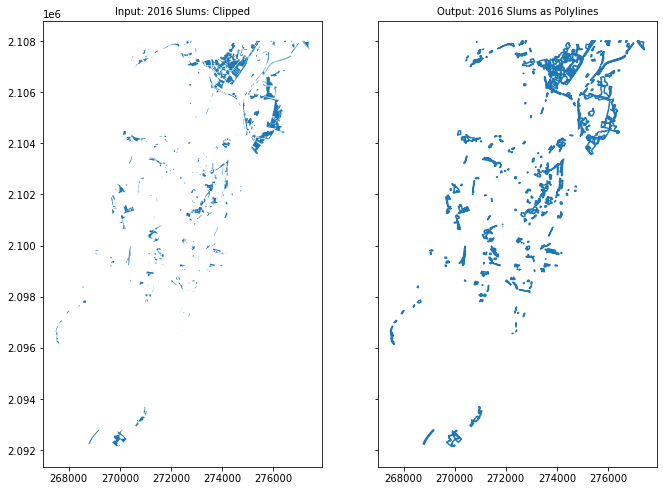

In [19]:
f, ax = plt.subplots(1,2, figsize=(11,11), sharey=True, sharex=True)
slum_clipped.plot(ax=ax[0])
slum_clipped_lines.plot(ax=ax[1])
ax[0].set_title(f'Input: 20{year} Slums: Clipped', fontsize=10)
ax[1].set_title(f'Output: 20{year} Slums as Polylines', fontsize=10)
plt.show()

### Calculate Euclidean distances

#### (a) Converting slum_clipped_lines to a raster
- Input: slum_clipped_line shapefile, 'Slum_Clipped_Lines.shp'
- Output: slum_clipped_line raster, 'slumClippedLines_raster.tif'

In [20]:
%%time
rasterize_shp(input_y_out, 'slumClippedLines_raster.tif', f'Slum_Clipped_Lines', cellSize)
checkm()

Current Size: 0.015 GB, Peak Usage: 0.086 GB
Wall time: 54.5 ms


#### (b) Compute distance to slum boundary and create a raster to store the distance
- Input: slum_clipped_line raster, 'slumClippedLines_raster.tif'
- Output: distance raster, 'euclidean_dist.tif'

In [21]:
def compute_proximity(output_dir, input_ras, out_ras):
    """Return distance between a cell and the closest boundary.
    
    The unit of distance is in georeferenced units and determined by the CRS of the input raster.
    """
    src = gdal.Open(f'{output_dir}/{input_ras}')
    srcband = src.GetRasterBand(1)
    dst = f'{output_dir}/{out_ras}'
    driver = gdal.GetDriverByName('GTiff')
    dst_raster = driver.Create(dst, src.RasterXSize, src.RasterYSize, 1, gdal.GetDataTypeByName('Float32'))
    dst_raster.SetGeoTransform(src.GetGeoTransform())
    dst_raster.SetProjection(src.GetProjectionRef())
    dstband = dst_raster.GetRasterBand(1) 
    gdal.ComputeProximity(srcband, dstband, ['DISTUNITS=GEO'])
    srcband = None
    dstband = None
    src = None
    dst_raster = None                                         

In [22]:
%%time
compute_proximity(input_y_out, 'slumClippedLines_raster.tif', 'euclidean_dist.tif')
checkm()

Current Size: 0.015 GB, Peak Usage: 0.086 GB
Wall time: 1.3 s


### Extract Slum and non-slum areas
Mask out regions of a raster that are outside the polygons defined in the shapefile.
- Input: euclidean distance raster, 'euclidean_dist.tif'
- Mask: Slum_Clipped shapefile & wards_minus_slums.shp
- Output: slum areas distance raster, 'slum_areas.tif'
- non-slum areas distance raster, 'non_slum_areas.tif'

In [23]:
def mask_raster(raster,shp,output,invert_flag):
    """Extract rasters based on shapefile.
    Raster: input raster file
    shp: input shapefile
    output: output raster file 
    invert: If False, pixels outside shapes will be masked. 
    If True, pixels inside shape will be masked.
    """
    with fiona.open(f'{input_y_out}/{shp}', 'r') as shapefile: 
        shapes = [feature['geometry'] for feature in shapefile]

    with rio.open(f'{input_y_out}/{raster}') as src: 
        out_image, out_trans_info = rio.mask.mask(src, shapes, invert=invert_flag)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_trans_info})

    with rio.open(f'{input_y_out}/{output}', "w", **out_meta) as dest:
        dest.write(out_image)

In [24]:
%%time
mask_raster('euclidean_dist.tif','Slum_Clipped.shp','slum_areas.tif',False)
checkm()

Current Size: 0.015 GB, Peak Usage: 0.383 GB
Wall time: 531 ms


In [25]:
%%time
mask_raster('euclidean_dist.tif','Slum_Clipped.shp','non_slum_areas.tif',True)
checkm()

Current Size: 0.011 GB, Peak Usage: 0.383 GB
Wall time: 591 ms


### Manual Reclassification
Reclassify the numeric values associated with slum and non-slum pixels to lie between 1 and 127, with 64-127 indicating slum and 1-63 non slum.

In [26]:
def manual_reclassification(output_dir, input_raster,no_of_classes,shift_factor,nonslum): 
    #Convert input raster to array
    ras = gdal.Open(f'{output_dir}/{input_raster}.tif')
    arr = ras.ReadAsArray() 
    
    #Change numpy array to dask array
    n_chunks=25
    arr = da.from_array(arr,chunks=(len(arr)//n_chunks))
    
    # IF is non-slum:
    if nonslum:
        # NOTE: arcpy MD nonslum bin's bound is used here for max_val, 
        # instead of "max_val = arr[arr < 1000].max()"
        min_val = arr.min().compute()
        if MD_MS_flag == 0: # MD
            max_val = 990.326094
        else:
            max_val = 976.638962 
            
        range_val = max_val - min_val
        interval_len = range_val/(no_of_classes-1)
        bins = np.arange(max_val, min_val, -interval_len)
        bins = np.append(9000, bins)
        bins = np.round(bins, 6)
        
        arr = da.digitize(arr, bins, right=False)
        arr = arr.astype(np.int8)
        arr += np.int8(shift_factor)
        arr = arr.compute()    
        
    # IF is slum:
    else:
        min_val = arr[arr >= 0].min().compute()
        max_val = arr.max().compute()
        range_val = max_val - min_val
        interval_len = range_val/no_of_classes
        bins = np.arange(min_val, max_val, interval_len)
        bins = np.round(bins, 6)
        
        arr = da.where(arr==0, -1, arr)
        arr = da.digitize(arr, bins, right=False)
        arr = arr.astype(np.int8)  
        arr = da.where(arr==0, np.int8(0), arr + np.int8(shift_factor))
        arr = arr.compute()  
    return arr

### Slum area reclassification

In [27]:
%%time
re_built = manual_reclassification(input_y_out, 'slum_areas', 64, 63, nonslum=False)
rasterize_array(input_y_out, re_built, 'slum_areas', 'slumRe')
checkm()

Current Size: 0.048 GB, Peak Usage: 0.383 GB
Wall time: 1.27 s


### Non-slum area reclassification

In [28]:
%%time
re_nonBuilt = manual_reclassification(input_y_out, 'non_slum_areas', 64, -1, nonslum=True)
rasterize_array(input_y_out, re_nonBuilt, 'non_slum_areas', 'nonSlumRe')
checkm()

Current Size: 0.085 GB, Peak Usage: 0.383 GB
Wall time: 639 ms


### Combine 'slumRe' and 'nonSlumRe' rasters
- Input: "slumRe.tif" & "nonSlumRe.tif"
- Output: Complete raster, "input_y.tif/png/jpeg"

In [29]:
%%time
rasters_to_join = [rio.open(f'{input_y_out}/{raster}.tif') for raster in ['slumRe', 'nonSlumRe']]
raster_mosaic, out_trans_info = merge(rasters_to_join)

out_meta = rasters_to_join[1].meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": raster_mosaic.shape[1],
                 "width": raster_mosaic.shape[2],
                 "transform": out_trans_info,
                 "crs": rasters_to_join[1].crs
                 })
with rio.open(f'{input_y_out}/input_y.tif', 'w', **out_meta) as output_path: 
    output_path.write(raster_mosaic)
raster_to_png(input_y_out,'input_y.tif','input_y')

Wall time: 1.06 s


In [31]:
print("Total Time used:", round((time.time()-st)/60, 2),"min")
checkm()

Total Time used: 0.22 min
Current Size: 0.199 GB, Peak Usage: 0.383 GB


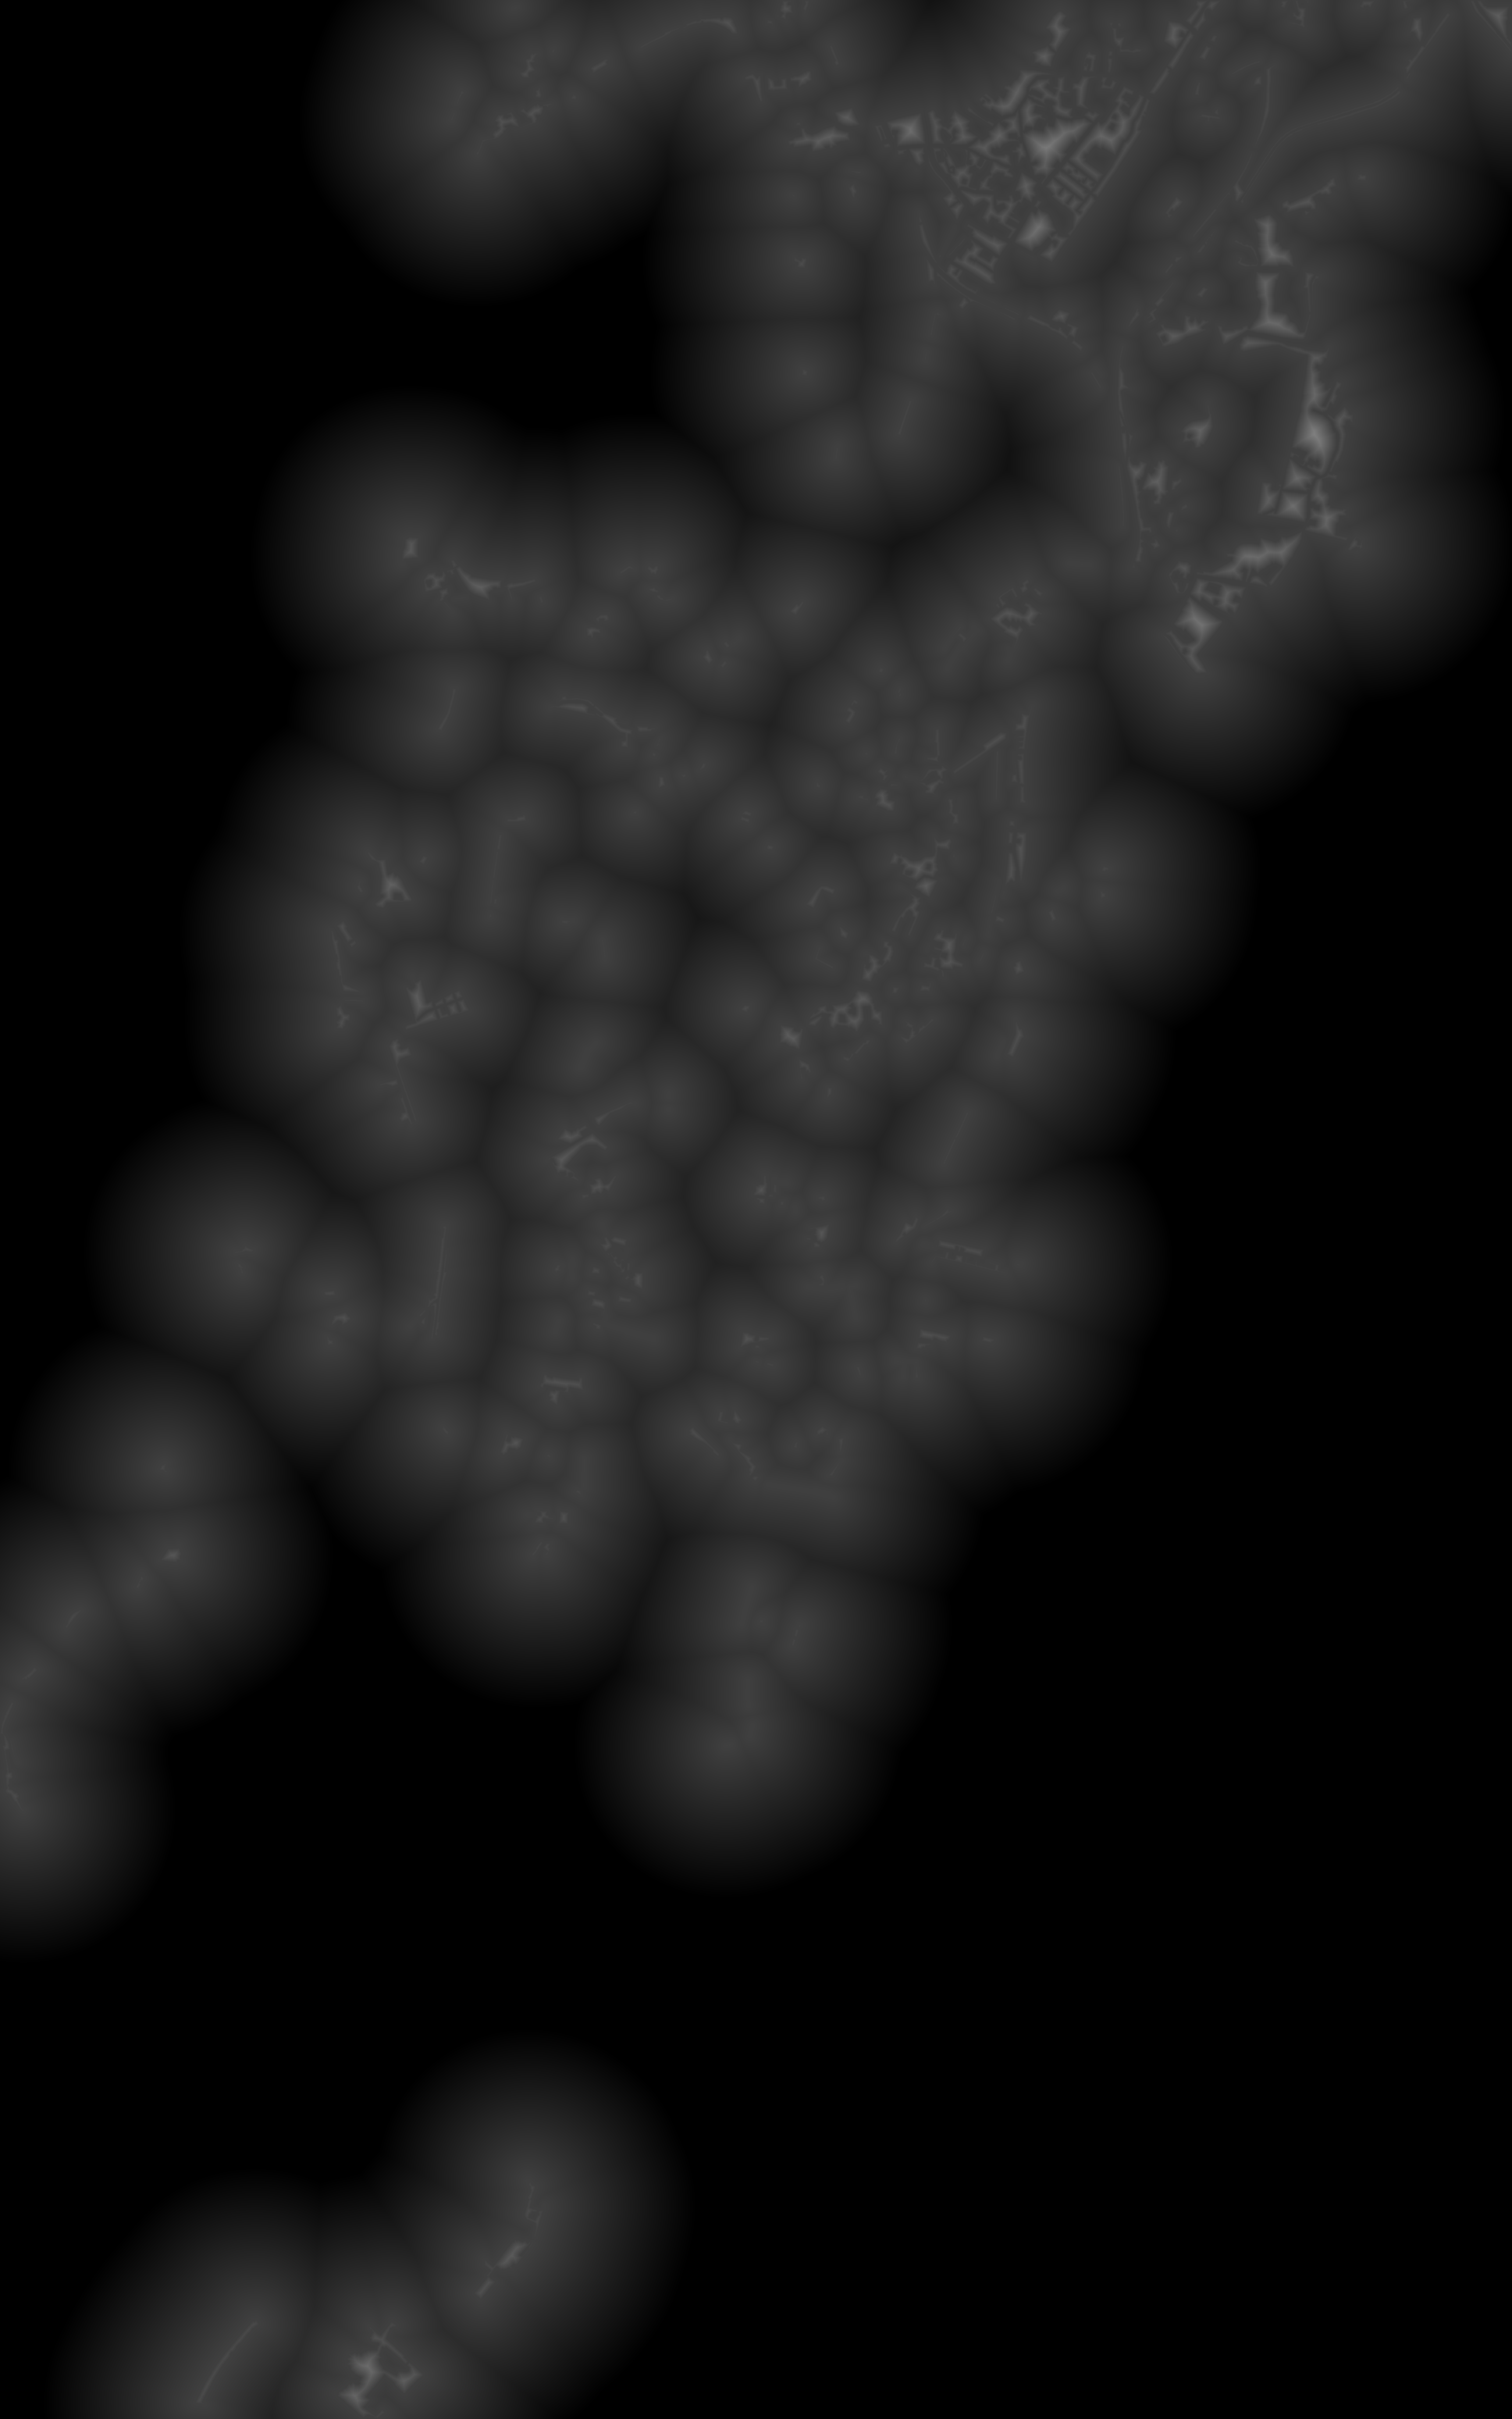

In [32]:
Image(filename = f'{input_y_out}/input_y.png', width=500, height=500)